In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
%pip install scikit-opt
from sko.PSO import PSO
import numpy as np
from scipy.fft import dct, idct
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.weight'] = 'bold' 

Note: you may need to restart the kernel to use updated packages.


# Rosenbrock function

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ----------- 2D NDCT Basis + Fit + Predict -----------
def ndct2_basis(x, y, Kx, Ky):
    """Construct the 2D Non-Discrete Cosine Transform (NDCT) basis matrix."""
    x = np.asarray(x).reshape(-1)
    y = np.asarray(y).reshape(-1)
    kx = np.arange(Kx + 1)
    ky = np.arange(Ky + 1)

    A = []
    for i in kx:
        for j in ky:
            # Basis term: cos(pi * i * x) * cos(pi * j * y)
            A.append(np.cos(np.pi * x * i) * np.cos(np.pi * y * j))
    return np.vstack(A).T  # Design matrix shape: (n_samples, (Kx+1)*(Ky+1))

def ndct2_fit(x, y, z, Kx, Ky, lam=0.0):
    """Fit NDCT coefficients using least squares (with optional regularization)."""
    A = ndct2_basis(x, y, Kx, Ky)
    n = A.shape[1]
    if lam and lam > 0:
        # Regularized least squares: (AᵀA + λI)c = Aᵀz
        ATA = A.T @ A
        ATz = A.T @ z
        c = np.linalg.solve(ATA + lam*np.eye(n), ATz)
    else:
        # Ordinary least squares fit
        c = np.linalg.lstsq(A, z, rcond=None)[0]
    return c.reshape(Kx+1, Ky+1)

def ndct2_predict(X, Y, coeffs):
    """Predict surface values using NDCT coefficients."""
    Kx, Ky = coeffs.shape[0]-1, coeffs.shape[1]-1
    Zhat = np.zeros_like(X, dtype=float)
    for i in range(Kx+1):
        for j in range(Ky+1):
            # Weighted cosine basis reconstruction
            Zhat += coeffs[i, j] * np.cos(np.pi * i * X) * np.cos(np.pi * j * Y)
    return Zhat

# ----------- Demo: Rosenbrock Function -----------
N = 20
x_lin = np.linspace(0.1, 1.9, N)
y_lin = np.linspace(0.1, 1.9, N)
X, Y = np.meshgrid(x_lin, y_lin)

# Flatten grid for sampling
X_flat = X.flatten()
Y_flat = Y.flatten()
M = X_flat.shape[0]

np.random.seed(16)  # For reproducibility

# Randomly select m sample points
m = 200
idx = np.random.choice(M, m, replace=False)
x_samples = X_flat[idx]
y_samples = Y_flat[idx]

# Generate Rosenbrock function samples
z_samples = (1 - x_samples)**2 + 100*(y_samples - x_samples**2)**2

# Add Gaussian noise to simulate measurement error
sigma = 0.3  # Standard deviation of noise
z_samples = z_samples + np.random.normal(0, sigma, size=z_samples.shape)

# Normalize input coordinates to [0, 1]
x_scaled = x_samples / 2
y_scaled = y_samples / 2


C:\Users\16941\AppData\Local\Temp\ipykernel_83272\4234009586.py:25: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs0.collections:


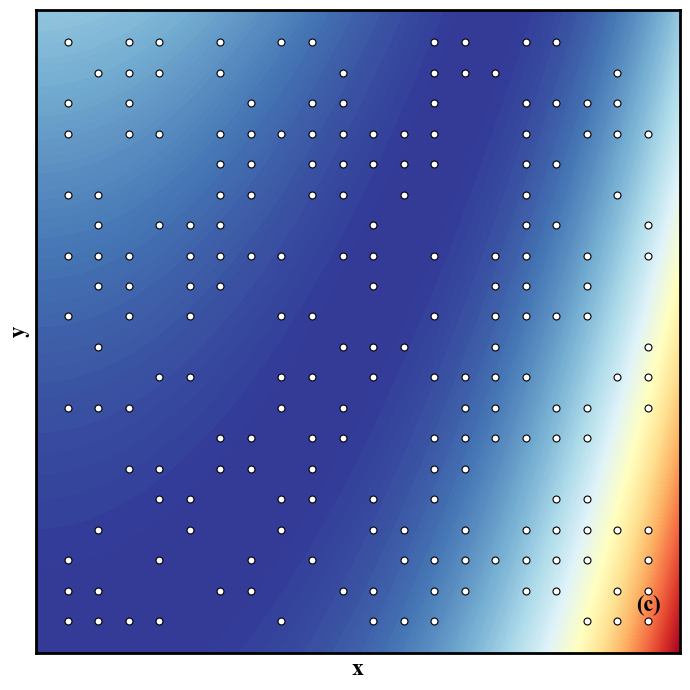

C:\Users\16941\AppData\Local\Temp\ipykernel_83272\4234009586.py:54: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs1.collections:


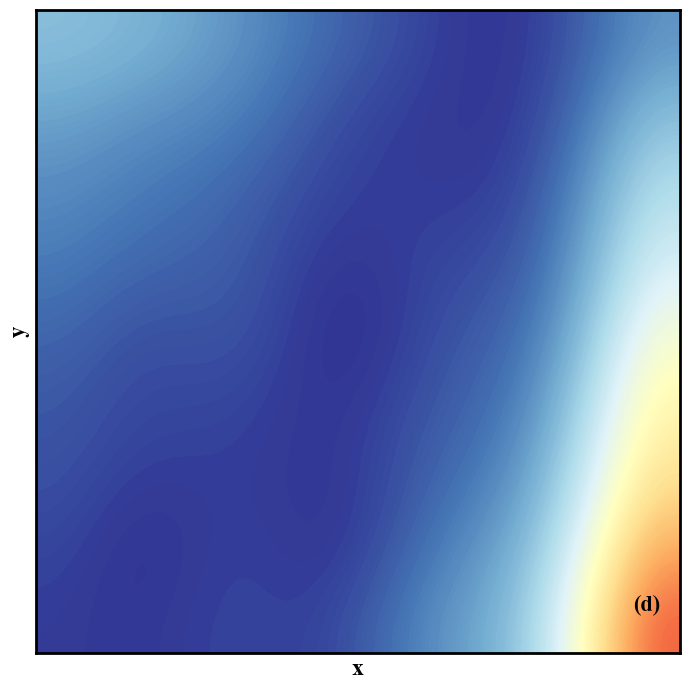

In [6]:
# ----------- Fit NDCT Model and Visualize Results -----------

t = 6
Kx, Ky = t, t
# Fit NDCT model with small Tikhonov regularization (λ = 1e-6)
coeffs = ndct2_fit(x_scaled, y_scaled, z_samples, Kx, Ky, lam=1e-6)

# Generate a dense grid for prediction
Xg, Yg = np.meshgrid(np.linspace(0, 2, 200), np.linspace(0, 2, 200))
Xg_scaled = Xg / 2
Yg_scaled = Yg / 2
# Predict surface using fitted NDCT coefficients
Zhat = ndct2_predict(Xg_scaled, Yg_scaled, coeffs)

# Compute ground truth (Rosenbrock function)
Ztrue = (1 - Xg)**2 + 100*(Yg - Xg**2)**2

# Shared color range for consistent visual comparison
vmin = min(Ztrue.min(), Zhat.min())
vmax = max(Ztrue.max(), Zhat.max())

# ----------- Figure (c): True Surface -----------
fig, ax = plt.subplots(figsize=(7, 7))
cs0 = ax.contourf(Xg, Yg, Ztrue, levels=200, cmap="RdYlBu_r", vmin=vmin, vmax=vmax)
for c in cs0.collections:
    c.set_rasterized(True)  # Prevent large vector files

# Plot sample points
ax.scatter(x_samples, y_samples, facecolors='white', edgecolors='black',
           s=25, linewidths=0.8, marker='o')

# Axis labels and figure tag
ax.set_xlabel('x', fontweight="bold", fontsize=17)
ax.set_ylabel('y', fontweight="bold", fontsize=16)
ax.text(0.97, 0.09, "(c)", transform=ax.transAxes,
        fontsize=16, fontweight="bold", ha="right", va="top")

# Remove ticks and labels for clean presentation
ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

# Thicken border lines for clarity
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
save_path = r"D:\lib\gali\Manuscript\fig3-2D-20x20\c.svg"
plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()

# ----------- Figure (d): NDCT-Predicted Surface -----------
fig, ax = plt.subplots(figsize=(7, 7))
cs1 = ax.contourf(Xg, Yg, Zhat, levels=200, cmap="RdYlBu_r", vmin=vmin, vmax=vmax)
for c in cs1.collections:
    c.set_rasterized(True)

# Axis labels and figure tag
ax.set_xlabel('x', fontweight="bold", fontsize=17)
ax.set_ylabel('y', fontweight="bold", fontsize=16)
ax.text(0.97, 0.09, "(d)", transform=ax.transAxes,
        fontsize=16, fontweight="bold", ha="right", va="top")

# Remove ticks and labels for clean presentation
ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

# Thicken border lines
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
save_path = r"D:\lib\gali\Manuscript\fig3-2D-20x20\d.svg"
plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()
